In [1]:
# !pip install -q pandas numpy scikit-learn matplotlib
import os, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 100)
print("Pustaka siap.")

Pustaka siap.


In [2]:
DATA_PATH = "toyota.csv"          # terkunci ke file ini
TARGET_COLUMN = "price"           # ganti jika perlu

assert os.path.exists(DATA_PATH), "File 'toyota.csv' harus berada satu folder dengan notebook."
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

print("\nInfo singkat:")
print(df.dtypes)

print("\nStatistik deskriptif (numerik):")
display(df.describe())

# Deteksi tipe kolom
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
if TARGET_COLUMN in numeric_cols:
    numeric_cols.remove(TARGET_COLUMN)

print("\nFitur numerik   :", numeric_cols)
print("Fitur kategorik :", cat_cols)

Shape: (6738, 9)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0



Info singkat:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

Statistik deskriptif (numerik):


,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000



Fitur numerik   : ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Fitur kategorik : ['model', 'transmission', 'fuelType']


In [3]:
# Missing values
na_counts = df.isna().sum().sort_values(ascending=False)
print("Jumlah missing values per kolom:")
display(na_counts)

# Persentase missing
na_pct = (df.isna().mean()*100).sort_values(ascending=False).round(2)
print("Persentase missing (%):")
display(na_pct)

# Duplikasi
dup_count = df.duplicated().sum()
print(f"Jumlah baris duplikat: {dup_count}")


Jumlah missing values per kolom:


,0
model,0
year,0
price,0
transmission,0
mileage,0
fuelType,0
tax,0
mpg,0
engineSize,0


Persentase missing (%):


,0
model,0.0
year,0.0
price,0.0
transmission,0.0
mileage,0.0
fuelType,0.0
tax,0.0
mpg,0.0
engineSize,0.0


Jumlah baris duplikat: 39


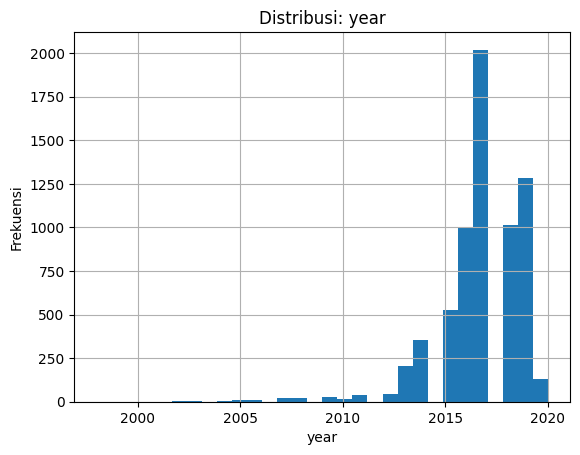

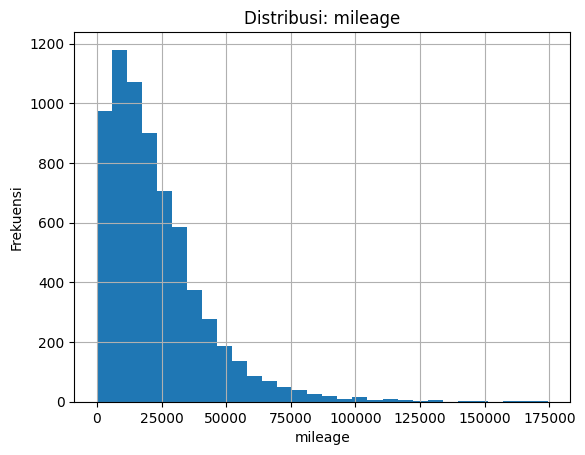

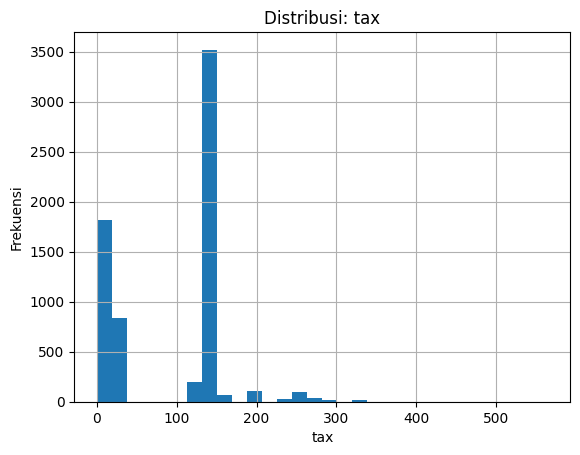

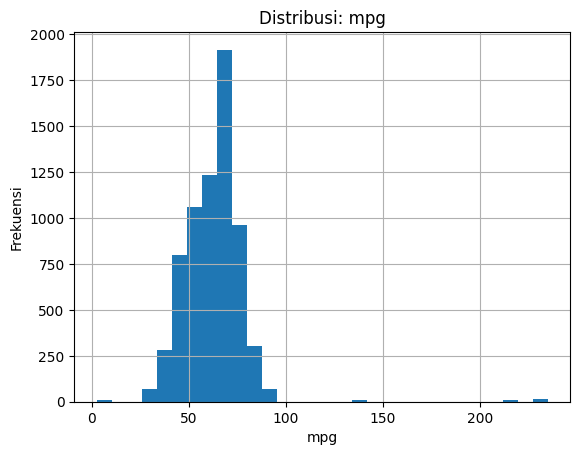

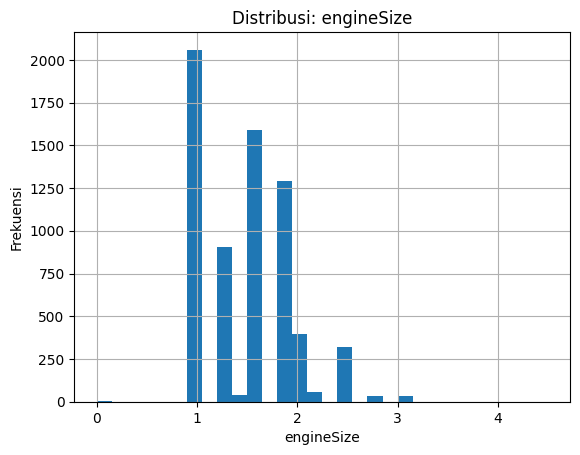

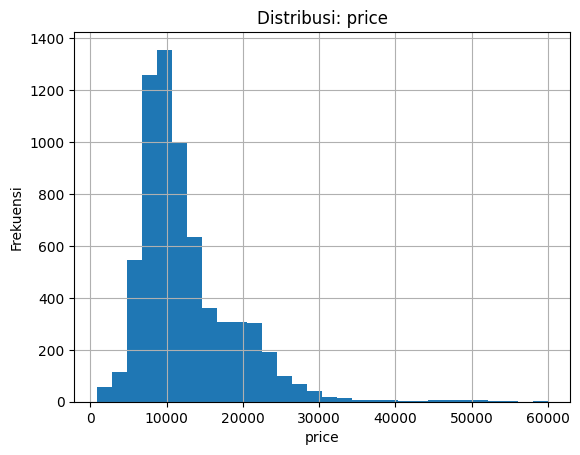

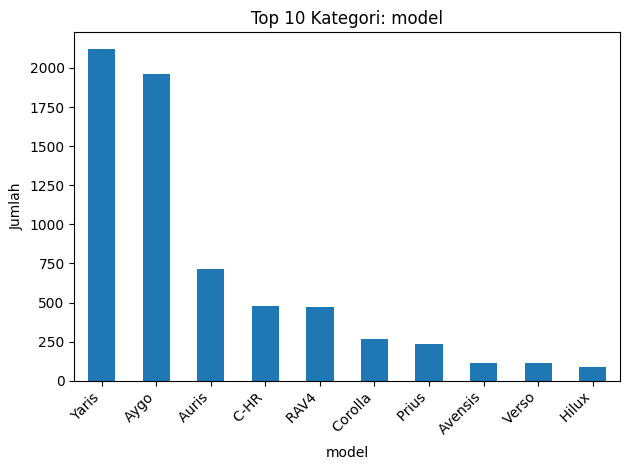

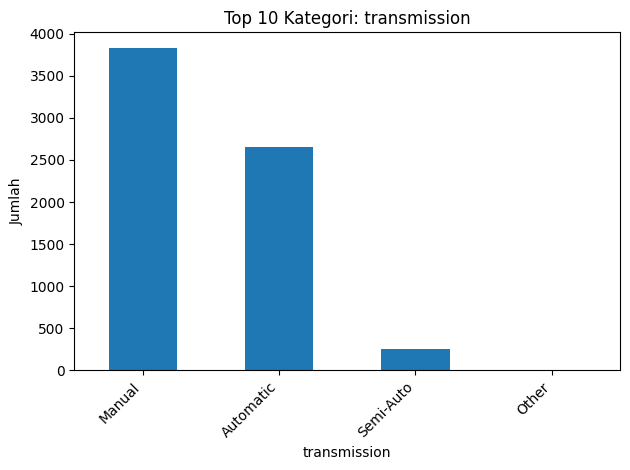

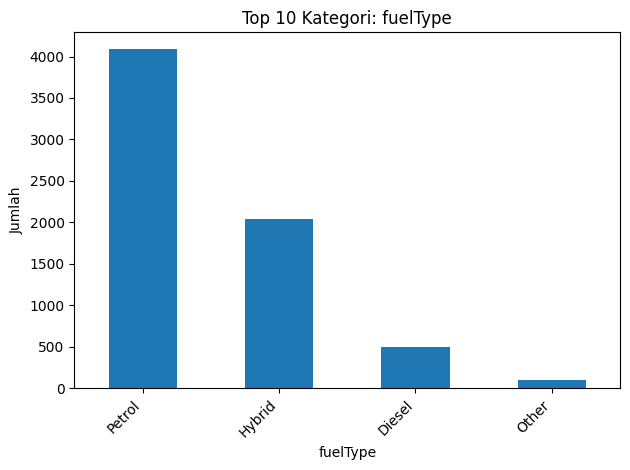

In [4]:
# Hist numerik (satu plot per fitur)
for col in numeric_cols + ([TARGET_COLUMN] if TARGET_COLUMN in df.columns and df[TARGET_COLUMN].dtype!='O' else []):
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Distribusi: {col}")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")
    plt.show()

# Bar chart untuk kategorikal (top 10)
for col in cat_cols:
    vc = df[col].astype(str).value_counts().head(10)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Top 10 Kategori: {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

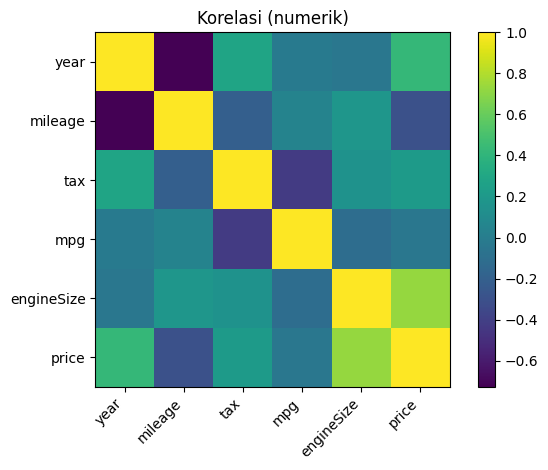

In [5]:
num_for_corr = numeric_cols.copy()
if TARGET_COLUMN in df.columns and pd.api.types.is_numeric_dtype(df[TARGET_COLUMN]):
    num_for_corr = num_for_corr + [TARGET_COLUMN]

if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr(numeric_only=True)
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title("Korelasi (numerik)")
    plt.colorbar()
    ticks = range(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=45, ha="right")
    plt.yticks(ticks, corr.columns)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak cukup kolom numerik untuk korelasi.")

In [6]:
# Drop duplikasi jika ada
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Baris sebelum/ sesudah drop duplicates: {before} -> {after}")

# Recompute tipe kolom setelah pembersihan
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
if TARGET_COLUMN in numeric_cols:
    numeric_cols.remove(TARGET_COLUMN)

Baris sebelum/ sesudah drop duplicates: 6738 -> 6699


In [7]:
assert TARGET_COLUMN in df.columns, f"Kolom target '{TARGET_COLUMN}' tidak ditemukan."
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print("Train:", X_train.shape, " Test:", X_test.shape)
display(X_train.head())

Train: (5359, 8)  Test: (1340, 8)


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
3858,Aygo,2017,Manual,11730,Petrol,0,68.9,1.0
4937,Aygo,2017,Semi-Auto,3876,Petrol,0,67.0,1.0
135,Corolla,2019,Automatic,9296,Hybrid,135,58.9,1.8
6569,Hilux,2018,Manual,14646,Diesel,265,40.4,2.4
3975,Aygo,2017,Manual,13229,Petrol,145,68.9,1.0


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

numeric_transformer = Pipeline([("scaler", StandardScaler(with_mean=False))])
categorical_transformer = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, X_train.select_dtypes(include=["number"]).columns.tolist()),
    ("cat", categorical_transformer, X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()),
])

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
pipe = Pipeline([("preprocess", preprocess), ("model", model)])
pipe.fit(X_train, y_train)
print("Training selesai.")

Training selesai.


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

pred_train = pipe.predict(X_train)
pred_test  = pipe.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test   = mean_absolute_error(y_test, pred_test)
r2_test    = r2_score(y_test, pred_test)

print(f"RMSE train: {rmse_train:.4f}")
print(f"RMSE test : {rmse_test:.4f}")
print(f"MAE test  : {mae_test:.4f}")
print(f"R2  test  : {r2_test:.4f}")

RMSE train: 473.5998
RMSE test : 1118.2634
MAE test  : 764.5988
R2  test  : 0.9698


,feature,importance
4,num__engineSize,0.557843
0,num__year,0.270149
3,num__mpg,0.044294
1,num__mileage,0.042843
14,cat__model_ Land Cruiser,0.024535
5,cat__model_ Auris,0.015770
23,cat__transmission_Automatic,0.010847
2,num__tax,0.007680
27,cat__fuelType_Hybrid,0.005261
24,cat__transmission_Manual,0.004146


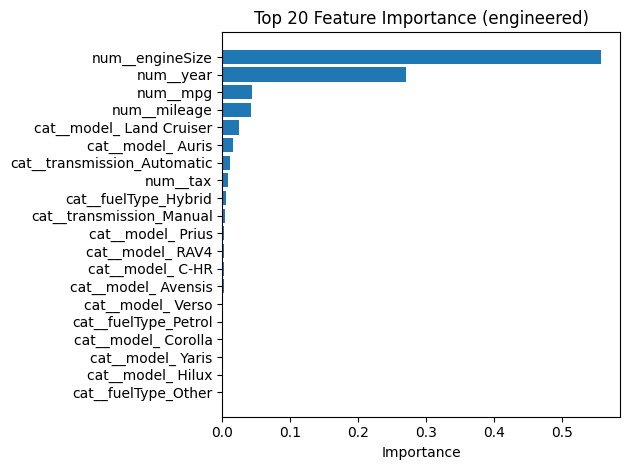

In [10]:
# Ambil nama fitur setelah transformasi
try:
    feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
except Exception:
    # fallback: gunakan kolom asli (kurang akurat untuk OHE)
    feat_names = pipe.named_steps["preprocess"].transformers_[0][2] + pipe.named_steps["preprocess"].transformers_[1][2]

importances = pipe.named_steps["model"].feature_importances_
imp = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
display(imp.head(20))

# Plot top 20 (satu plot)
top = imp.head(20).iloc[::-1]  # balik biar bar chart dari kecil ke besar
plt.figure()
plt.barh(top["feature"], top["importance"])
plt.title("Top 20 Feature Importance (engineered)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [11]:
with open("model.pkl", "wb") as f:
    pickle.dump(pipe, f)

with open("columns.json", "w") as f:
    json.dump(X.columns.tolist(), f, ensure_ascii=False, indent=2)

example = X_train.iloc[0:1].to_dict(orient="records")[0]
with open("example_features.json", "w") as f:
    json.dump(example, f, ensure_ascii=False, indent=2)

print("Disimpan: model.pkl, columns.json, example_features.json")

Disimpan: model.pkl, columns.json, example_features.json


In [12]:
with open("model.pkl", "rb") as f:
    loaded = pickle.load(f)

pred_one = float(loaded.predict(X_test.iloc[0:1])[0])
print("Prediksi 1 baris (sanity check):", pred_one)

Prediksi 1 baris (sanity check): 8174.723333333333


In [13]:
import joblib
joblib.dump(pipe, "model.pkl")


['model.pkl']